In [4]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [5]:
# Step 1: Load the dataset
file_path = 'heart_disease_uci.csv'
df = pd.read_csv(file_path)

# Data Cleaning and Preprocessing

In [6]:
# 2.1 Handle missing values
df = df.dropna()

In [7]:
# 2.2 Handle duplicates
df = df.drop_duplicates()

In [8]:
# 2.3 Handle outliers by Z-score method
df = df[(np.abs(stats.zscore(df.select_dtypes(include=[float, int]))) < 3).all(axis=1)]


In [9]:
# Step 3: Standardize Data Formats and Units
scaler = StandardScaler()
df[df.select_dtypes(include=[float, int]).columns] = scaler.fit_transform(df.select_dtypes(include=[float, int]))


# Descriptive Statistics

In [10]:
# 4.1 Calculate summary statistics
summary_stats = df.describe()

In [11]:
# 4.2 Calculate mean, median, and standard deviation for numeric columns
mean_values = df.select_dtypes(include=[np.number]).mean()
median_values = df.select_dtypes(include=[np.number]).median()
std_dev_values = df.select_dtypes(include=[np.number]).std()

In [12]:
# 4.3 Explore data distributions and assess skewness and kurtosis
skewness = df.select_dtypes(include=[np.number]).skew()
kurtosis = df.select_dtypes(include=[np.number]).kurtosis()

In [13]:
# Print summary statistics
print("Summary Statistics:\n", summary_stats)
print("\nMean Values:\n", mean_values)
print("\nMedian Values:\n", median_values)
print("\nStandard Deviation Values:\n", std_dev_values)
print("\nSkewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Summary Statistics:
                  id           age      trestbps          chol      thalch  \
count  2.880000e+02  2.880000e+02  2.880000e+02  2.880000e+02  288.000000   
mean  -9.868649e-17  2.744718e-16  7.617364e-16  2.744718e-16    0.000000   
std    1.001741e+00  1.001741e+00  1.001741e+00  1.001741e+00    1.001741   
min   -1.703907e+00 -2.796120e+00 -2.182524e+00 -2.586361e+00   -2.750839   
25%   -8.770912e-01 -8.110358e-01 -6.537363e-01 -7.344754e-01   -0.715857   
50%   -4.814412e-03  1.263653e-01 -6.574113e-02 -6.997526e-02    0.140391   
75%    8.674623e-01  7.329190e-01  5.222541e-01  6.380987e-01    0.718637   
max    1.717009e+00  2.497439e+00  2.874235e+00  3.252526e+00    2.319934   

          oldpeak            ca           num  
count  288.000000  2.880000e+02  2.880000e+02  
mean     0.000000 -2.467162e-17 -2.467162e-17  
std      1.001741  1.001741e+00  1.001741e+00  
min     -0.928462 -7.115579e-01 -7.518860e-01  
25%     -0.928462 -7.115579e-01 -7.518860e-01

# Feature Selection

In [14]:
# 6.1 Convert categorical columns to numerical
df_encoded = pd.get_dummies(df, drop_first=True)

In [15]:
# 6.2 Calculate the correlation matrix on the encoded dataframe
correlation_matrix = df_encoded.corr()

In [16]:
# 6.3 Select features with high correlation with the target variable 'num'
high_correlation_features = correlation_matrix.index[abs(correlation_matrix["num"]) > 0.5]
df_selected_features = df_encoded[high_correlation_features]

# Feature Creation

In [ ]:
# 7.1 Creating a new feature 'age_group' based on 'age'
df_selected_features['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 70, 80], labels=['0-30', '30-40', '40-50', '50-60', '60-70', '70-80'])


# Data Transformation

In [18]:
# 8.1 Handle categorical variables
df_transformed = pd.get_dummies(df_selected_features, drop_first=True)


In [19]:
# Step 8.2: Convert the target variable 'num' to integer to ensure it is categorical
df_transformed['num'] = df_transformed['num'].astype(int)

In [20]:
# Step 9: Display the cleaned and processed dataframe
print("\nCleaned and Processed Heart Disease Dataset:")
print(df_transformed.head())


Cleaned and Processed Heart Disease Dataset:
         ca  num  thal_normal  age_group_30-40  age_group_40-50  \
0 -0.711558    0        False            False            False   
1  2.541278    0         True            False            False   
2  1.456999    0        False            False            False   
3 -0.711558    0         True            False            False   
4 -0.711558    0         True            False            False   

   age_group_50-60  age_group_60-70  age_group_70-80  
0            False            False            False  
1            False            False            False  
2            False            False            False  
3            False            False            False  
4            False            False            False  


# Visualizations

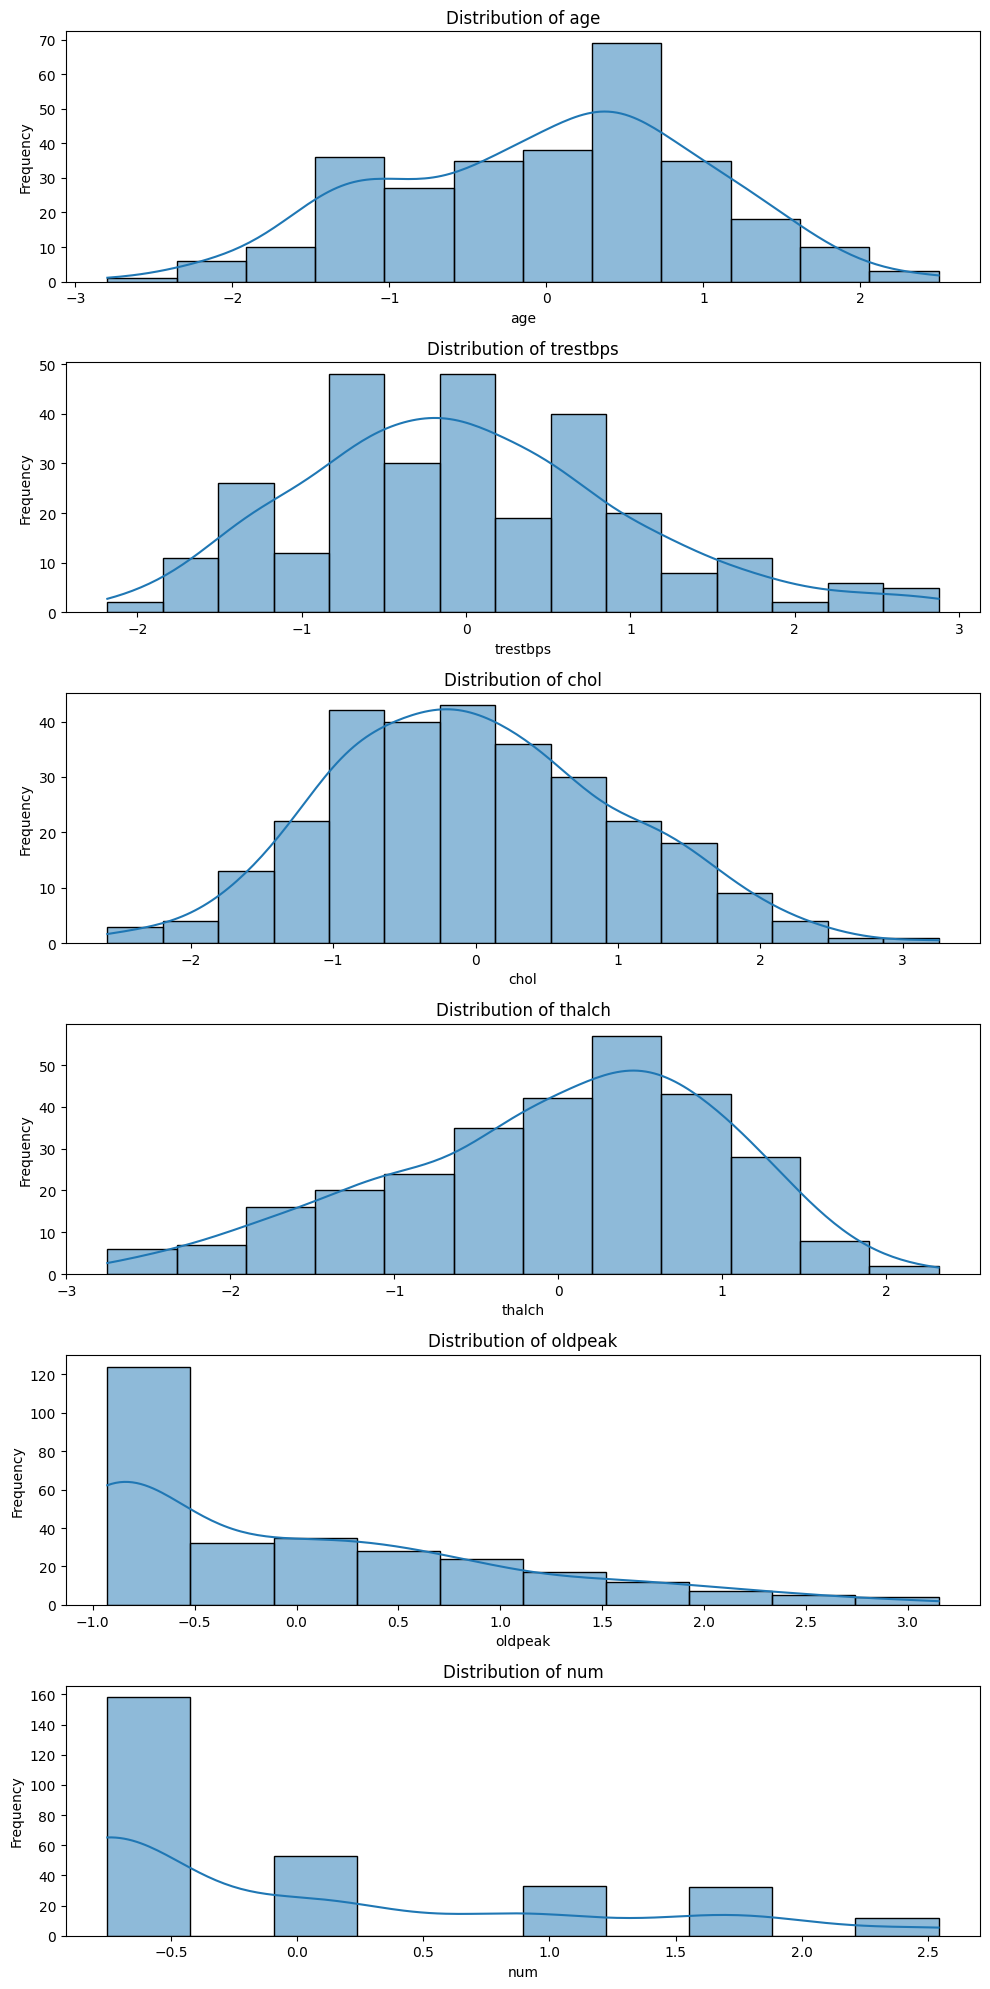

In [21]:
# 10.1 Histograms for numerical features
num_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num']
df_num = df[num_features]

fig, axs = plt.subplots(len(num_features), 1, figsize=(10, 20))

for i, feature in enumerate(num_features):
    sns.histplot(df[feature], kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

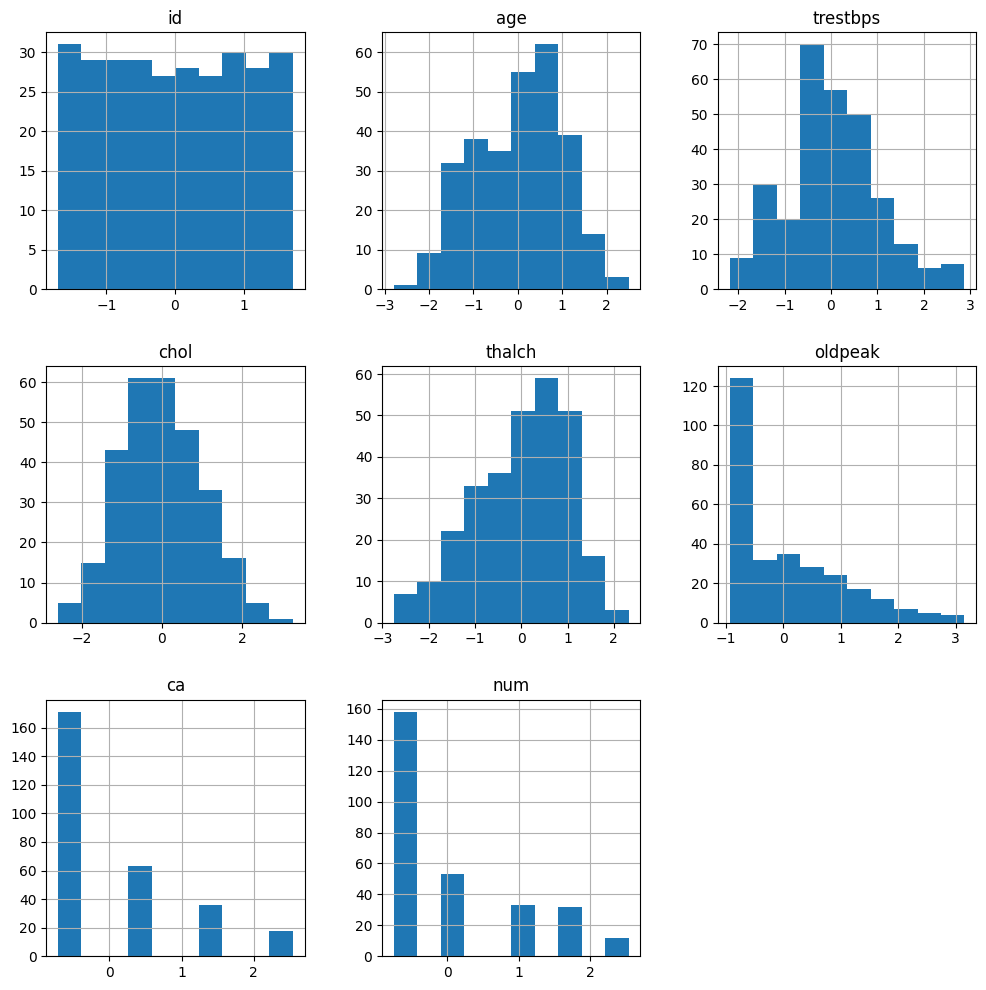

In [22]:
# 1. Histograms
df.hist(figsize=(12, 12))
plt.show()

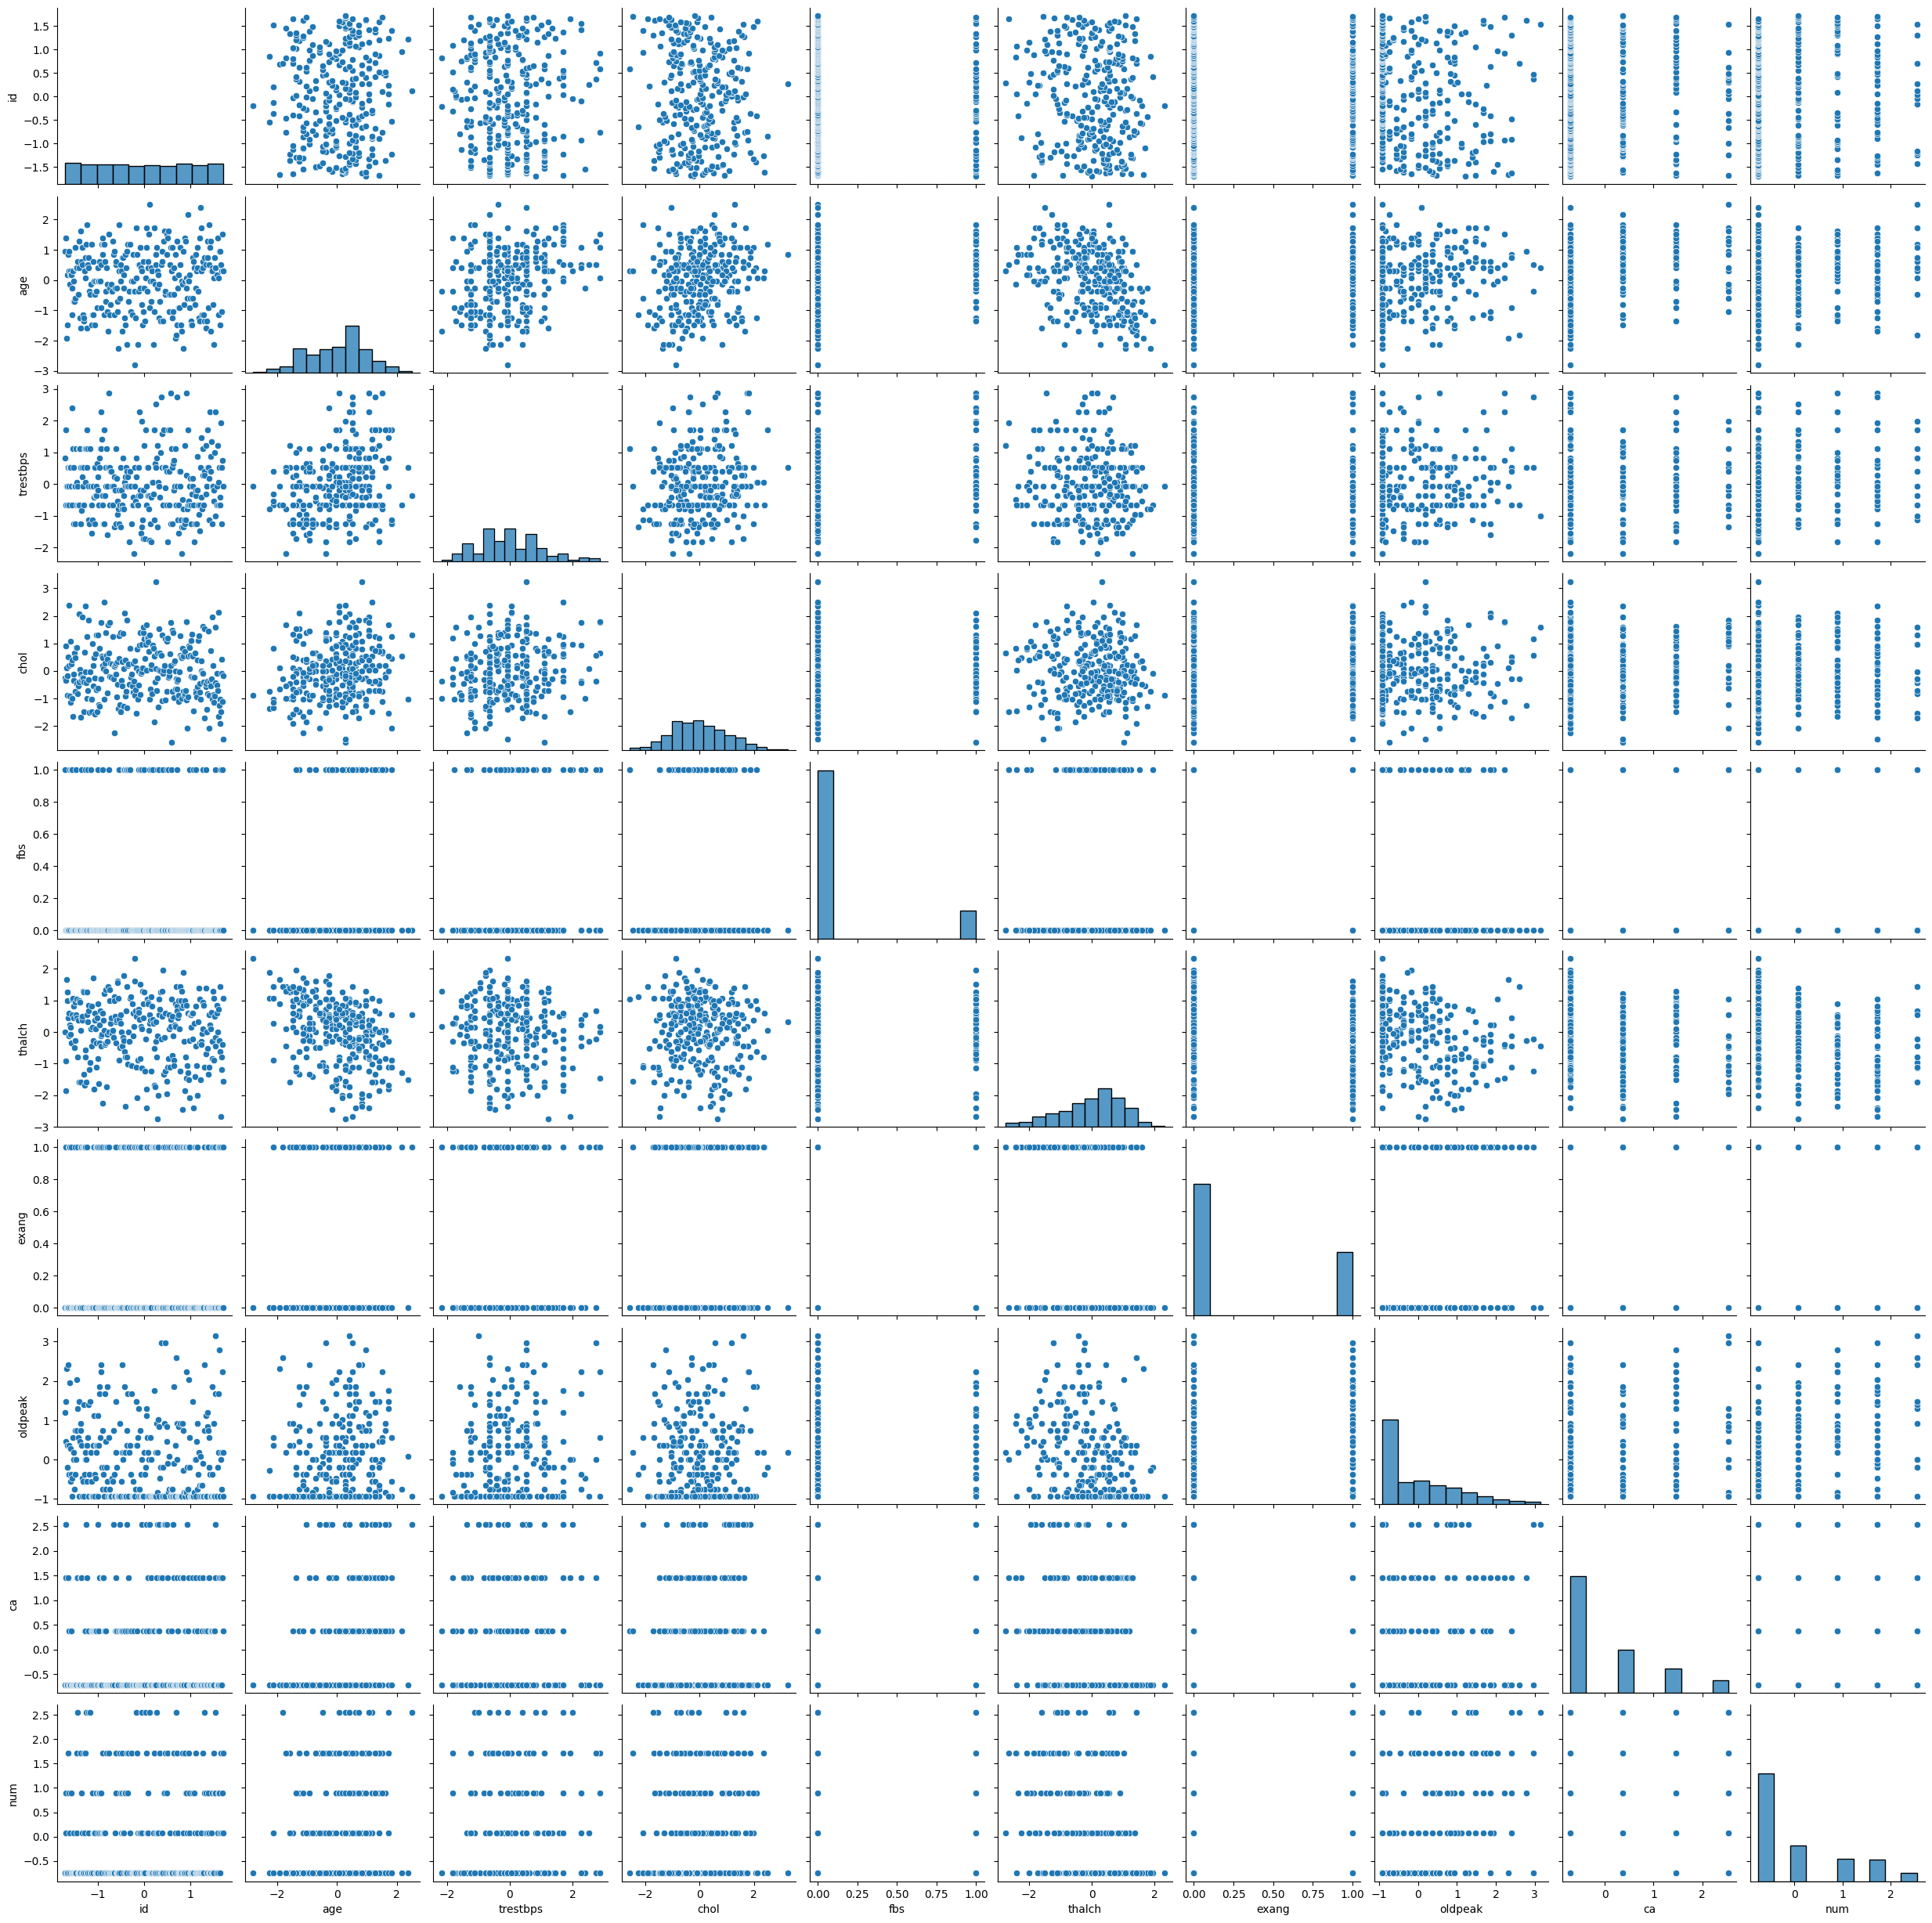

In [23]:
# 2. Scatter plots
sns.pairplot(df)
plt.show()

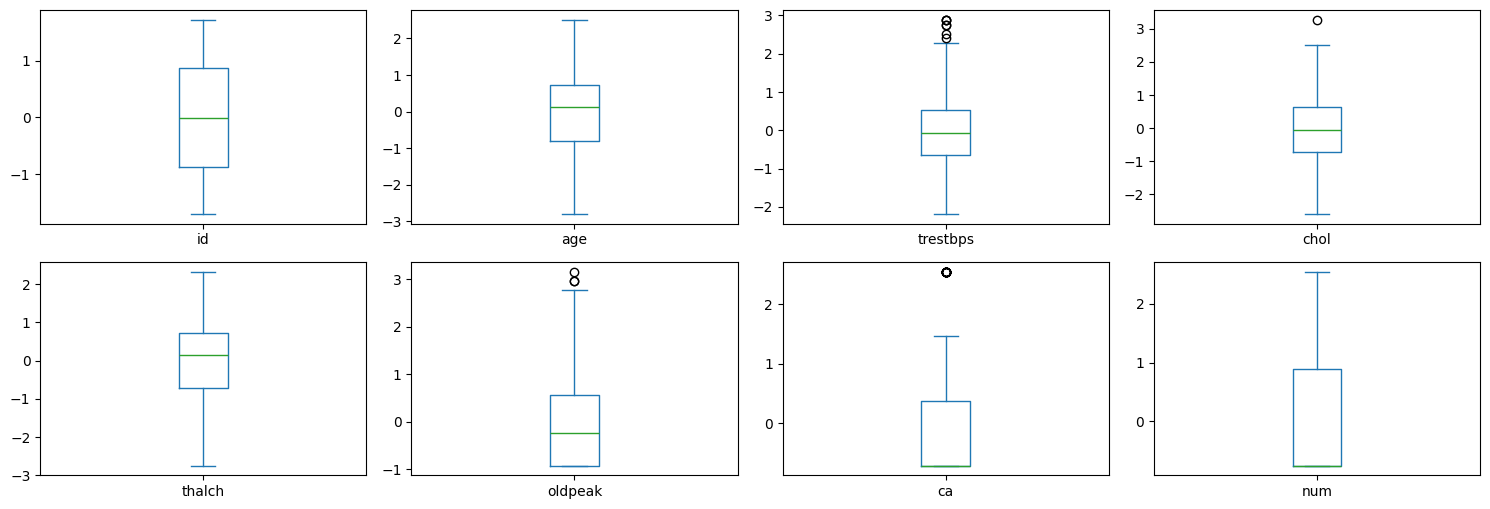

In [24]:
# 3. Box plots
num_cols = len(df.columns)
layout = (int(np.ceil(num_cols / 4)), 4)
df.plot(kind='box', subplots=True, layout=layout, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Model Selection, Training, and Validation

In [25]:
# 11.1 Split data into training, validation, and test sets
X = df_transformed.drop(columns=['num'])
y = df_transformed['num']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [26]:
# Step 11.2: Apply SMOTE to handle imbalanced classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [27]:
# 11.3 Choose and apply a machine learning algorithm (RandomForestClassifier)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Hyperparameter Tuning

In [28]:
# 12.1 Optimize model hyperparameters using Grid Search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


In [29]:
# 12.2 Train the model with the best parameters
grid_search.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [30]:
# Validation
y_val_pred = grid_search.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.51      0.65        35
           1       0.18      0.67      0.29         6
           2       0.00      0.00      0.00         2

    accuracy                           0.51        43
   macro avg       0.36      0.39      0.31        43
weighted avg       0.76      0.51      0.57        43



In [31]:
# Testing
y_test_pred = grid_search.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))


Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.47      0.64        34
           1       0.22      0.71      0.33         7
           2       0.20      0.33      0.25         3

    accuracy                           0.50        44
   macro avg       0.47      0.51      0.41        44
weighted avg       0.82      0.50      0.56        44



In [32]:
# Best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
